# Large Scale Kernel Methods

## sklearn's SVC vs sklearn's LinearSVC vs Random Fourier Features method vs Nyström's method

In [1]:
import numpy as np
from scipy import linalg
from tqdm import tqdm # optional
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

from sklearn.svm import SVC, LinearSVC
from time import time

## Loading and splitting dataset

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.bz2'
ijcnn1 = load_svmlight_file(dataset_path)

X = ijcnn1[0]
y = ijcnn1[1]
print(type(X))            # X is a scipy CSR matrix, Y is a numpy array
X = X.toarray()           # Let's convert X to a numpy array so we can use StandardScaler() 

###############################################################################
# Extracting features

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 20000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("n° of training samples:", n1)
print("n° of test samples:", n2)
print("n° of features:", p)

<class 'scipy.sparse.csr.csr_matrix'>
n° of training samples: 20000
n° of test samples: 29990
n° of features: 22


## sklearn SVC vs LinearSVC

In [3]:
print("Fitting Linear SVC on %d samples..." % X_train.shape[0])
t0 = time()
linear_clf = LinearSVC(dual = False)     # Build a LinearSVC model
linear_clf.fit(X_train,y_train)          # Train it
t_fit_linear_clf = time() - t0
print("done in %0.3fs" % t_fit_linear_clf)
print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t0 = time()
linear_clf.predict(X_test)               # Use it to predict outputs
t_predict_linear_clf = time() - t0
print("done in %0.3fs" % t_predict_linear_clf)
accuracy_linear = linear_clf.score(X_test,y_test)    # Get accuracy
print("classification accuracy: %0.3f" % accuracy_linear)


print("Fitting SVC on %d samples..." % X_train.shape[0])
t0 = time()
kernel_clf = SVC()                       # Build a Gaussian SVC model
kernel_clf.fit(X_train,y_train)          # Train it
t_fit_kernel_clf = time() - t0
print("done in %0.3fs" % t_fit_kernel_clf)
print("Predicting with SVC on %d samples..." % X_test.shape[0])
t0 = time()
kernel_clf.predict(X_test)               # Use it to predict outputs
t_predict_kernel_clf = time() - t0
print("done in %0.3fs" % (t_predict_kernel_clf))
accuracy_kernel = kernel_clf.score(X_test,y_test)    # Get accuracy
print("classification accuracy: %0.3f" % accuracy_kernel)   



## Comparing times and accuracies

print("-----------------------------------------------------------")
print("training : LinearSVC is %0.2f times faster than Gaussian SVC" % (t_fit_kernel_clf/t_fit_linear_clf))
print("decoding : LinearSVC is %0.2f times faster that Gaussian SVC" % (t_predict_kernel_clf/t_predict_linear_clf))
print("accuracy : Gaussian SVC model is %0.2f times more accurate than LinearSVC" % (accuracy_kernel/accuracy_linear))

Fitting Linear SVC on 20000 samples...
done in 0.156s
Predicting with LinearSVC on 29990 samples...
done in 0.092s
classification accuracy: 0.923
Fitting SVC on 20000 samples...
done in 6.401s
Predicting with SVC on 29990 samples...
done in 4.436s
classification accuracy: 0.975
-----------------------------------------------------------
training : LinearSVC is 40.96 times faster than Gaussian SVC
decoding : LinearSVC is 48.07 times faster that Gaussian SVC
accuracy : Gaussian SVC model is 1.06 times more accurate than LinearSVC


## K-rank approximation of a matrix

Let's define a function to calculate a k-rank approximation of a Gram matrix, using Scipy's spectral decomposition svds (fast) versus svd (slow)

In [4]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd


# k-th order approximation of the Gram Matrix G.
# Parameters
#     ----------
#    gram_mat : array, shape (n_samples, n_samples) : the Gram matrix
#    k : int : the order approximation
#    fast : bool : use svd (if False) or svds (if True)
# Return
#    -----
#    gram_mat_k : array, shape (n_samples, n_samples) : The rank k Gram matrix.

def rank_trunc(gram_mat, k, fast = True):
    if fast:
        u, s, vh = svds(gram_mat, k, which='LM')     # Getting k largest singular values 
        sigma = np.zeros((k,k))                      
        for i in range(k):                           
            sigma[i,i] = s[i]                        # Filling a diagonal matrix with the k largest singular values
        gram_mat_k = u @ sigma @ vh                  # Constructing the k-rank approximation matrix

        return gram_mat_k
    
    else:
        u, s, vh = svd(gram_mat)                     # Getting all singular values
        sigma = np.zeros(gram_mat.shape)        
        for i in range(k):         
            sigma[i,i] = s[i]                        # Filling a diagonal matrix with the k largest singular values
        
        for i in range(k+1, gram_mat.shape[0]):     
            u[:,i] = 0                               # Deleting all values of u and vh for index larger than k
            vh[i,:] = 0                              
        gram_mat_k = u @ sigma @ vh                  # Constructing the k-rank approximation matrix       
        
        return gram_mat_k



## Comparing the two versions of k-rank approximation

and plotting the results against k

199it [00:23,  8.61it/s]


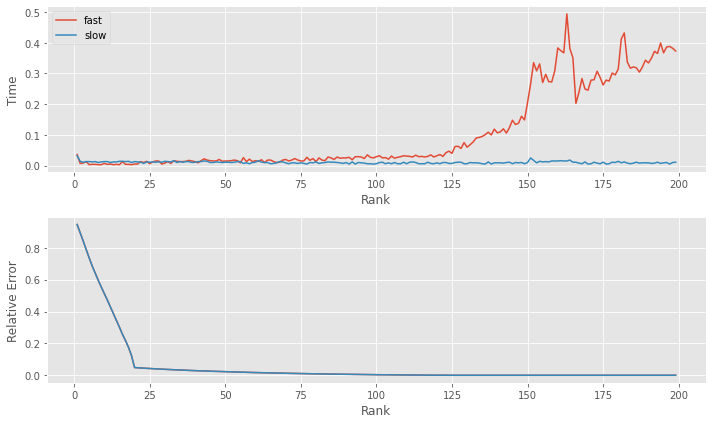

In [5]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)       

X_noise = rng.normal(loc =0, scale = 1, size = (100, 200))    # Creating a normal distributed random noise 
gram_noise = np.transpose(X_noise) @ X_noise                 
                                                             
X_signal = rng.normal(loc =0, scale = 1, size = (20, 200))    # Creating a normally distributed random signalrandomidem avec X_signal
gram_signal = np.transpose(X_signal) @ X_signal

gram = intensity * gram_signal + gram_noise


n_ranks = 199                                                  
ranks = np.arange(1, n_ranks + 1)                           # Creating results tables
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error_slow = np.zeros(n_ranks)
rel_error_fast = np.zeros(n_ranks)

for k, rank in tqdm(enumerate(ranks)):
    t0 = time()
    foo = rank_trunc(gram,rank, fast = True)                 # Measuring the function on fast mode...
    timing_fast[k] = time() - t0
    
    t0 = time()
    bar = rank_trunc(gram,rank, fast = False)                  # ... and slow mode
    timing_slow[k] = time() - t0                               

    # Getting errors with Frobenius norm
    rel_error_fast[k] =np.linalg.norm(foo - gram , ord = 'fro') / np.linalg.norm(gram, ord = 'fro')
    rel_error_slow[k] = np.linalg.norm(bar - gram , ord = 'fro') / np.linalg.norm(gram, ord = 'fro')


    
# Display
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()
ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()
ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')

ax2.plot(ranks, rel_error_slow, '-', label = 'slow')
ax2.plot(ranks, rel_error_fast, '-', label = 'fast')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
#ax2.set_ylim([-1, 2])
plt.tight_layout()
plt.show()




## Comments
The relative errors are striclty the same with the two methods as intended.
It is useless to  use a k-rank higher than 25 in this case.
Using Scipy's svd is counter-intuitively faster than svds, since svd computes all 200 singular values when svds computes only the k largest. 


## Random Fourier features algorithm

In [6]:
from sklearn.kernel_approximation import RBFSampler

def random_features(X_train, X_test, gamma, c=300, seed=42):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    
    W = rng.normal(loc =0, scale = 2 * gamma, size = (X_train.shape[1],c))  # Creating normally distributed random values
    b = rng.uniform(low=0.0, high=2 * np.pi, size=(1,c))                    # Creating uniformly distributed random values
    
    X_new_train = np.zeros((X_train.shape[0],c))                            
    X_new_test = np.zeros((X_test.shape[0],c))                              

    for i in range (X_train.shape[0]):                                      
        X_new_train[i,:] = np.sqrt(2/c) * np.cos( X_train[i,:] @ W +b )     

    for i in range(X_test.shape[0]):
        X_new_test[i,:] = np.sqrt(2/c) * np.cos( X_test[i,:] @ W +b )
    
    return X_new_train, X_new_test

 Let's use it with $c=300$.

In [7]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features
Z_train, Z_test = random_features(X_train, X_test, gamma, 300, 42)
print("Fitting Random Fourier features methods on %d samples..." % n_samples)
t0 = time()
linear_clf.fit(Z_train, y_train)
t_fit_rand_feat = time() -t0
print("done in %0.3fs" % t_fit_rand_feat)

print("Predicting with Random Fourier features methods on %d samples..." % n_samples_test)
t0 = time()
linear_clf.predict(Z_test)
t_predict_rand_feat = time()-t0
print("done in %0.3fs" % t_predict_rand_feat)
accuracy_rand_feat = linear_clf.score(Z_test, y_test)
print("classification accuracy: %0.3f\n" % accuracy_rand_feat)


Fitting Random Fourier features methods on 20000 samples...
done in 2.206s
Predicting with Random Fourier features methods on 29990 samples...
done in 0.033s
classification accuracy: 0.941



## Nyström algorithm

In [8]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    
    I = []
    X = np.zeros((c,X_train.shape[1]))
    rng = np.random.RandomState(seed)
    for i in range(c):                                            
        I.append(rng.randint(low = 0, high = X_train.shape[0]))  # Randomly picking c rows out of X_train
        X[i,:] = X_train[I[i],:]                                 # and copying them in matrix X
        
    Wij = rbf_kernel(X,  gamma = gamma)                          # Getting X's Gram matrix

       
    u, s, vh = svd(Wij)                      # Getting the singular values
    sigma = np.zeros((k,k))                  
    for i in range(k):
        sigma[i,i] = s[i]                    # and filling a diagonal matrix with the k largest
    
    u = np.delete(u, range(k,c), axis = 1)   # Deleting all values for u and vh for index larger than k
    vh = np.delete(vh, range(k,c), axis = 0) 
    
    Mk = u @ np.sqrt(np.linalg.inv(sigma))  
    
    C_train = rbf_kernel(X_train, X, gamma = gamma)   # Creating C_train and C_test
    C_test = rbf_kernel(X_test, X, gamma = gamma)
    
    X_new_train = C_train @ Mk
    X_new_test = C_test @ Mk
    
    return X_new_train, X_new_test

Let's use it with $c=500$ and $k=300$

In [9]:

n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting with Nyström methods on %d samples..." % n_samples)
t0 = time()
linear_clf.fit(Z_train, y_train)
t_fit_nystrom = time() - t0
print("done in %0.3fs" % t_fit_nystrom)

print("Predicting Nyström methods on %d samples..." % n_samples_test)
t0 = time()
linear_clf.predict(Z_test)
t_predict_nystrom = time()-t0
print("done in %0.3fs" % t_predict_nystrom)
accuracy_nystrom = linear_clf.score(Z_test, y_test)
print("classification accuracy: %0.3f\n" % accuracy_nystrom)



print("Training time:")
print("%0.3fs - With LinearSVC (primal mode)" % t_fit_linear_clf)
print("%0.3fs - With random Fourier features methods" % t_fit_rand_feat)
print("%0.3fs - With SVC (Gaussian kernel)" % t_fit_kernel_clf)
print("%0.3fs - With Nyström's methods\n" % t_fit_nystrom)


print("Comparaison de temps de prédiction:")
print("%0.3fs - With LinearSVC (primal mode)" % t_predict_linear_clf)
print("%0.3fs - With random Fourier features methods" % t_predict_rand_feat)
print("%0.3fs - With SVC (Gaussian kernel)" % t_predict_kernel_clf)
print("%0.3fs - With Nyström's methods\n" % t_predict_nystrom)


print("Comparaison de l'accuracy:")
print("%0.3f - With LinearSVC (primal mode)" % accuracy_linear)
print("%0.3f - With random Fourier features methods" % accuracy_rand_feat)
print("%0.3f - With SVC (Gaussian kernel)" % accuracy_kernel)
print("%0.3f - With Nyström's methods\n" % accuracy_nystrom)


Fitting with Nyström methods on 20000 samples...
done in 1.859s
Predicting Nyström methods on 29990 samples...
done in 0.032s
classification accuracy: 0.968

Training time:
0.156s - With LinearSVC (primal mode)
2.206s - With random Fourier features methods
6.401s - With SVC (Gaussian kernel)
1.859s - With Nyström's methods

Comparaison de temps de prédiction:
0.092s - With LinearSVC (primal mode)
0.033s - With random Fourier features methods
4.436s - With SVC (Gaussian kernel)
0.032s - With Nyström's methods

Comparaison de l'accuracy:
0.923 - With LinearSVC (primal mode)
0.941 - With random Fourier features methods
0.975 - With SVC (Gaussian kernel)
0.968 - With Nyström's methods



## Vizualization and conclusions

12it [01:10,  5.89s/it]


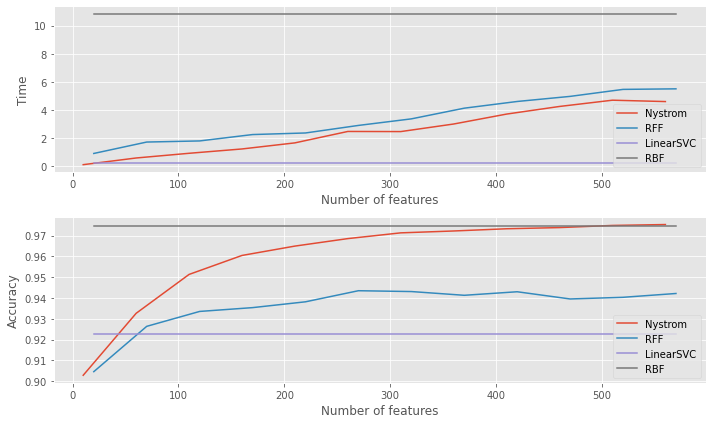

In [10]:
ranks = np.arange(20, 600, 50)               # Initiating the results variables
n_ranks = len(ranks)
timing_rff = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
accuracy_nystrom = np.zeros(n_ranks)
accuracy_rff = np.zeros(n_ranks)
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

for i, c in tqdm(enumerate(ranks)):
# Computing time & accuracy for random kernel features methods versus rank k
    
    t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c, 42)
    linear_clf.fit(Z_train, y_train)
    linear_clf.predict(Z_test)
    timing_rff[i] = time()-t0
    accuracy_rff[i] = linear_clf.score(Z_test, y_test)

# Then Nyström's methods
    
    t0 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    linear_clf.fit(Z_train, y_train)
    linear_clf.predict(Z_test)
    timing_nystrom[i] = time()-t0
    accuracy_nystrom[i] = linear_clf.score(Z_test, y_test)

# Computing time and accuracy for SVC and LinearSVC don't depend on rank k. We'll find they are constant
timing_linear = t_fit_linear_clf + t_predict_linear_clf
timing_kernel = t_fit_kernel_clf + t_predict_kernel_clf


# Display
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rff, '-', label='RFF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rff, '-', label='RFF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()



## Comments :
For both computation time and accuracy we find that :
sklearn.svm.SVC >= Nystrom > random Fourier features > sklearn.svm.LinearSCV.
Nystrom's methods gets the best results , with just a little more computation time than LinearSVC and an accuracy
just below SVC